In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
import cell2location
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

/home/bailab/miniconda3/envs/cell2location/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
results_folder = '/data/project/AI4Omic/MASLD/results/ST/cell2location'
ref_run_name = f'{results_folder}/reference_signatures'

In [3]:
sc.settings.figdir = results_folder
sc.settings.set_figure_params(dpi=300, dpi_save=300, format='pdf', fontsize=10)

In [ ]:
adata = sc.read_h5ad('/data/project/AI4Omic/MASLD/results/scRNA/CellphoneDB/adata_major.h5ad')
adata.obs['disease_status'] = pd.Categorical(adata.obs['disease_status'], categories=['CTRL', 'MASLD', 'MASH'], ordered=True)
adata.uns['disease_status_colors'] = ['#a6cee3', '#fdbf6f', '#b15928']

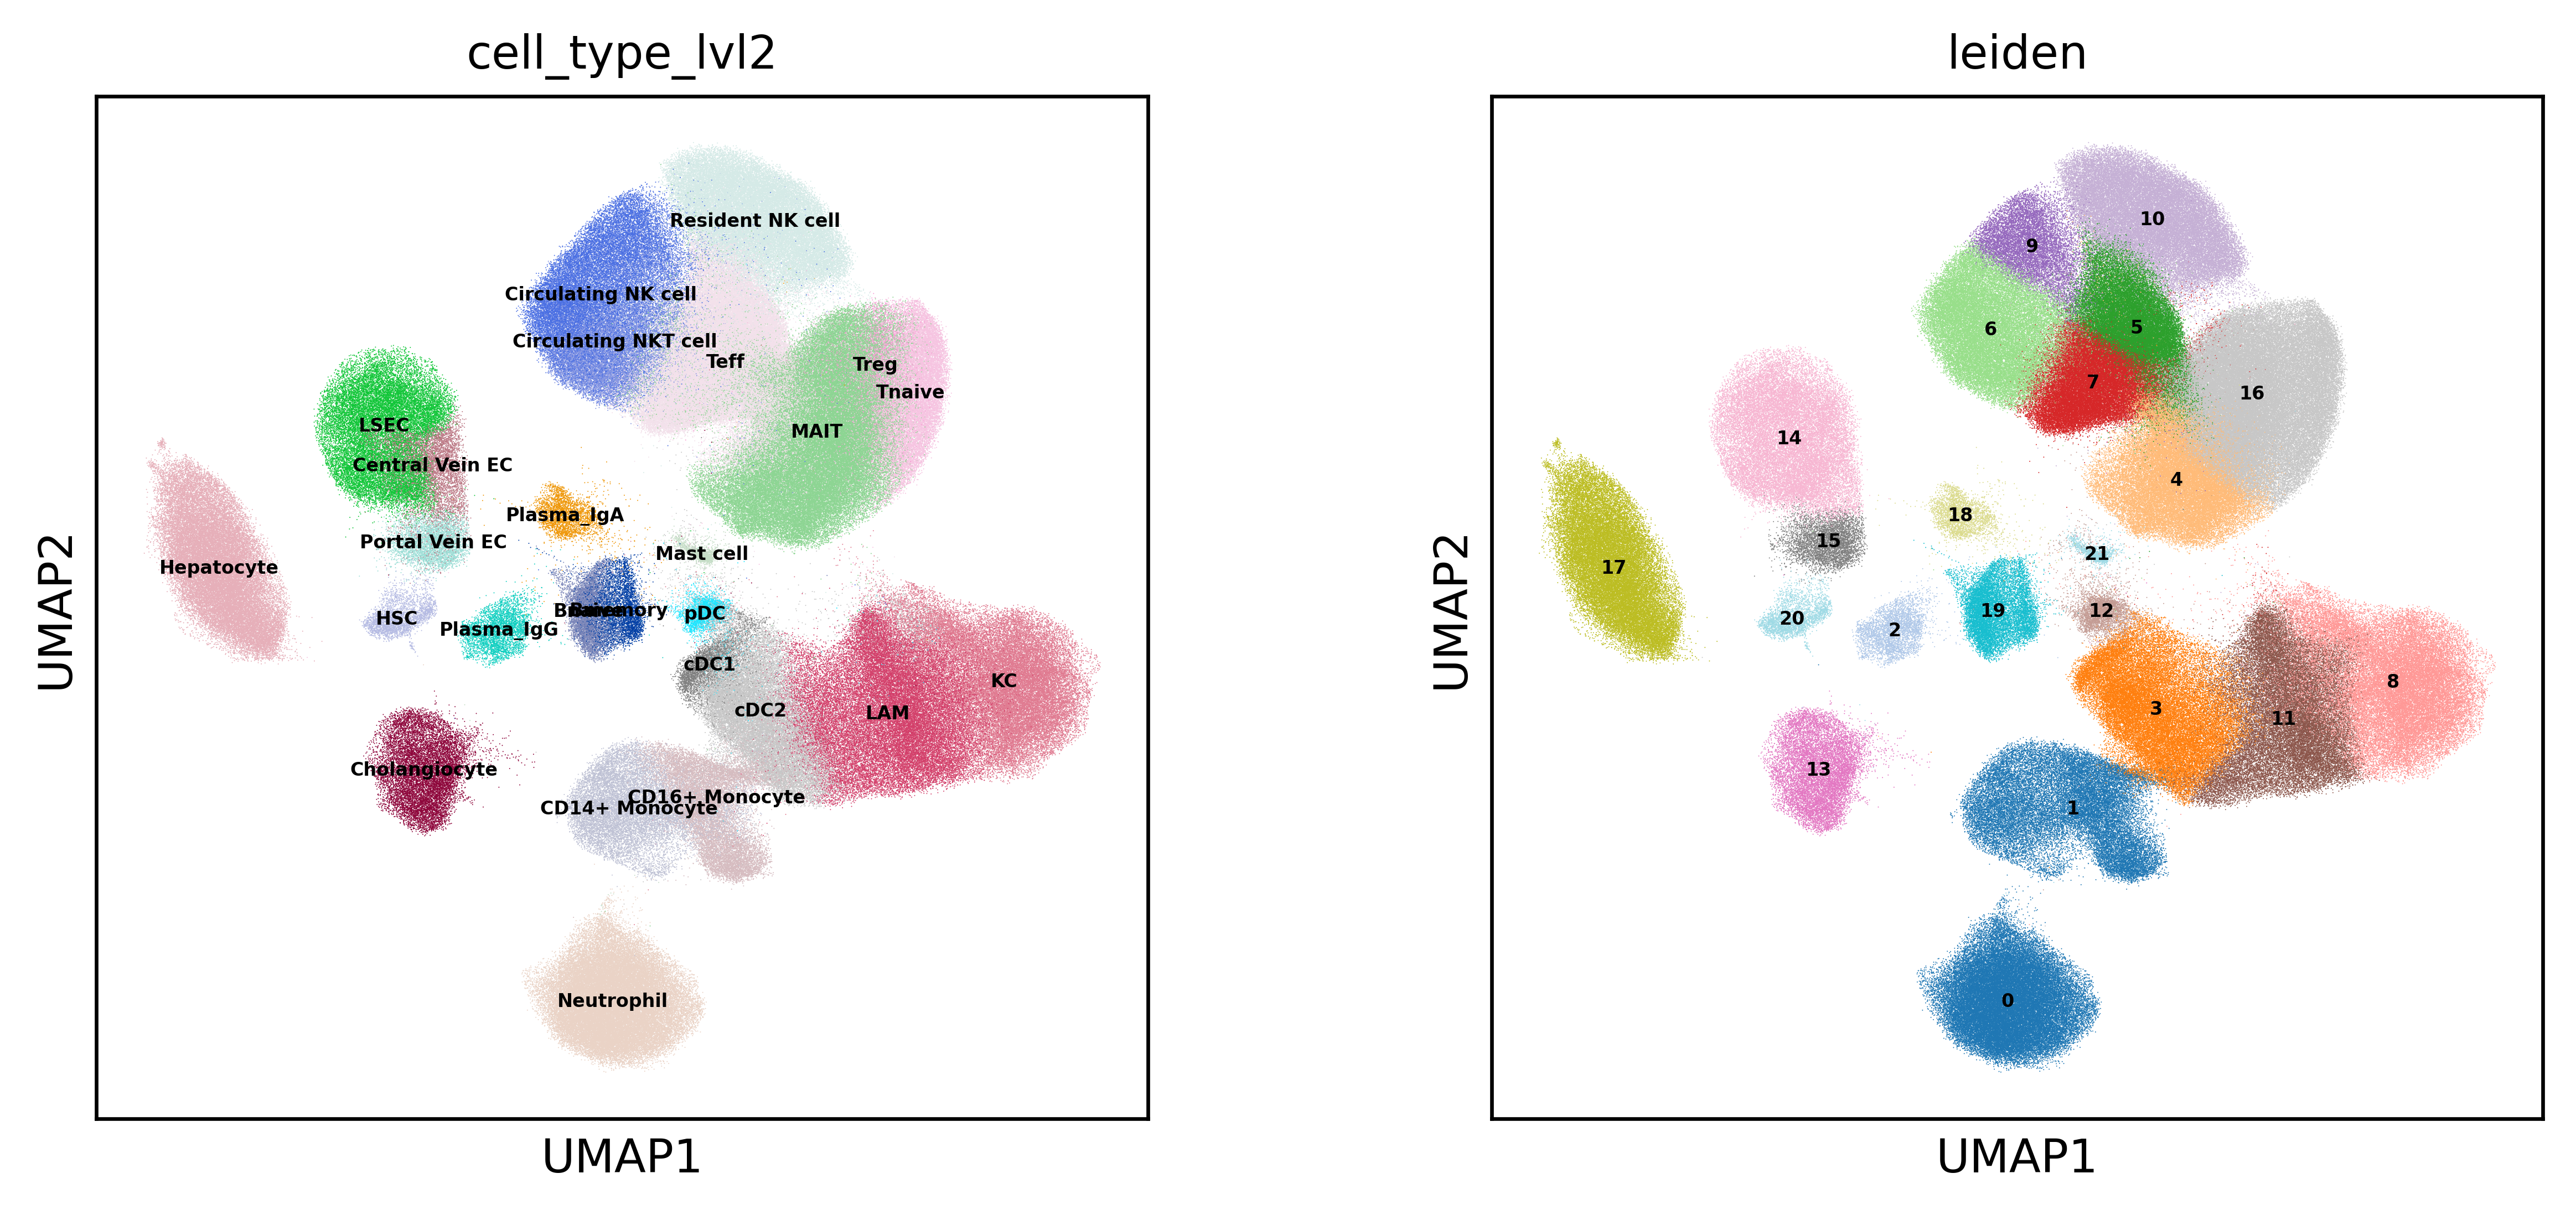

In [5]:
sc.pl.umap(adata, color=['cell_type_lvl2', 'leiden'], frameon=True, legend_loc='on data', legend_fontsize=4)

In [7]:
adata.X = adata.layers['counts'].copy()
adata_ref = adata.copy()
adata_ref.var['SYMBOL'] = adata_ref.var.index
#adata_ref.var.set_index('gene_ids',drop=True,inplace=True)

/home/bailab/miniconda3/envs/cell2location/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


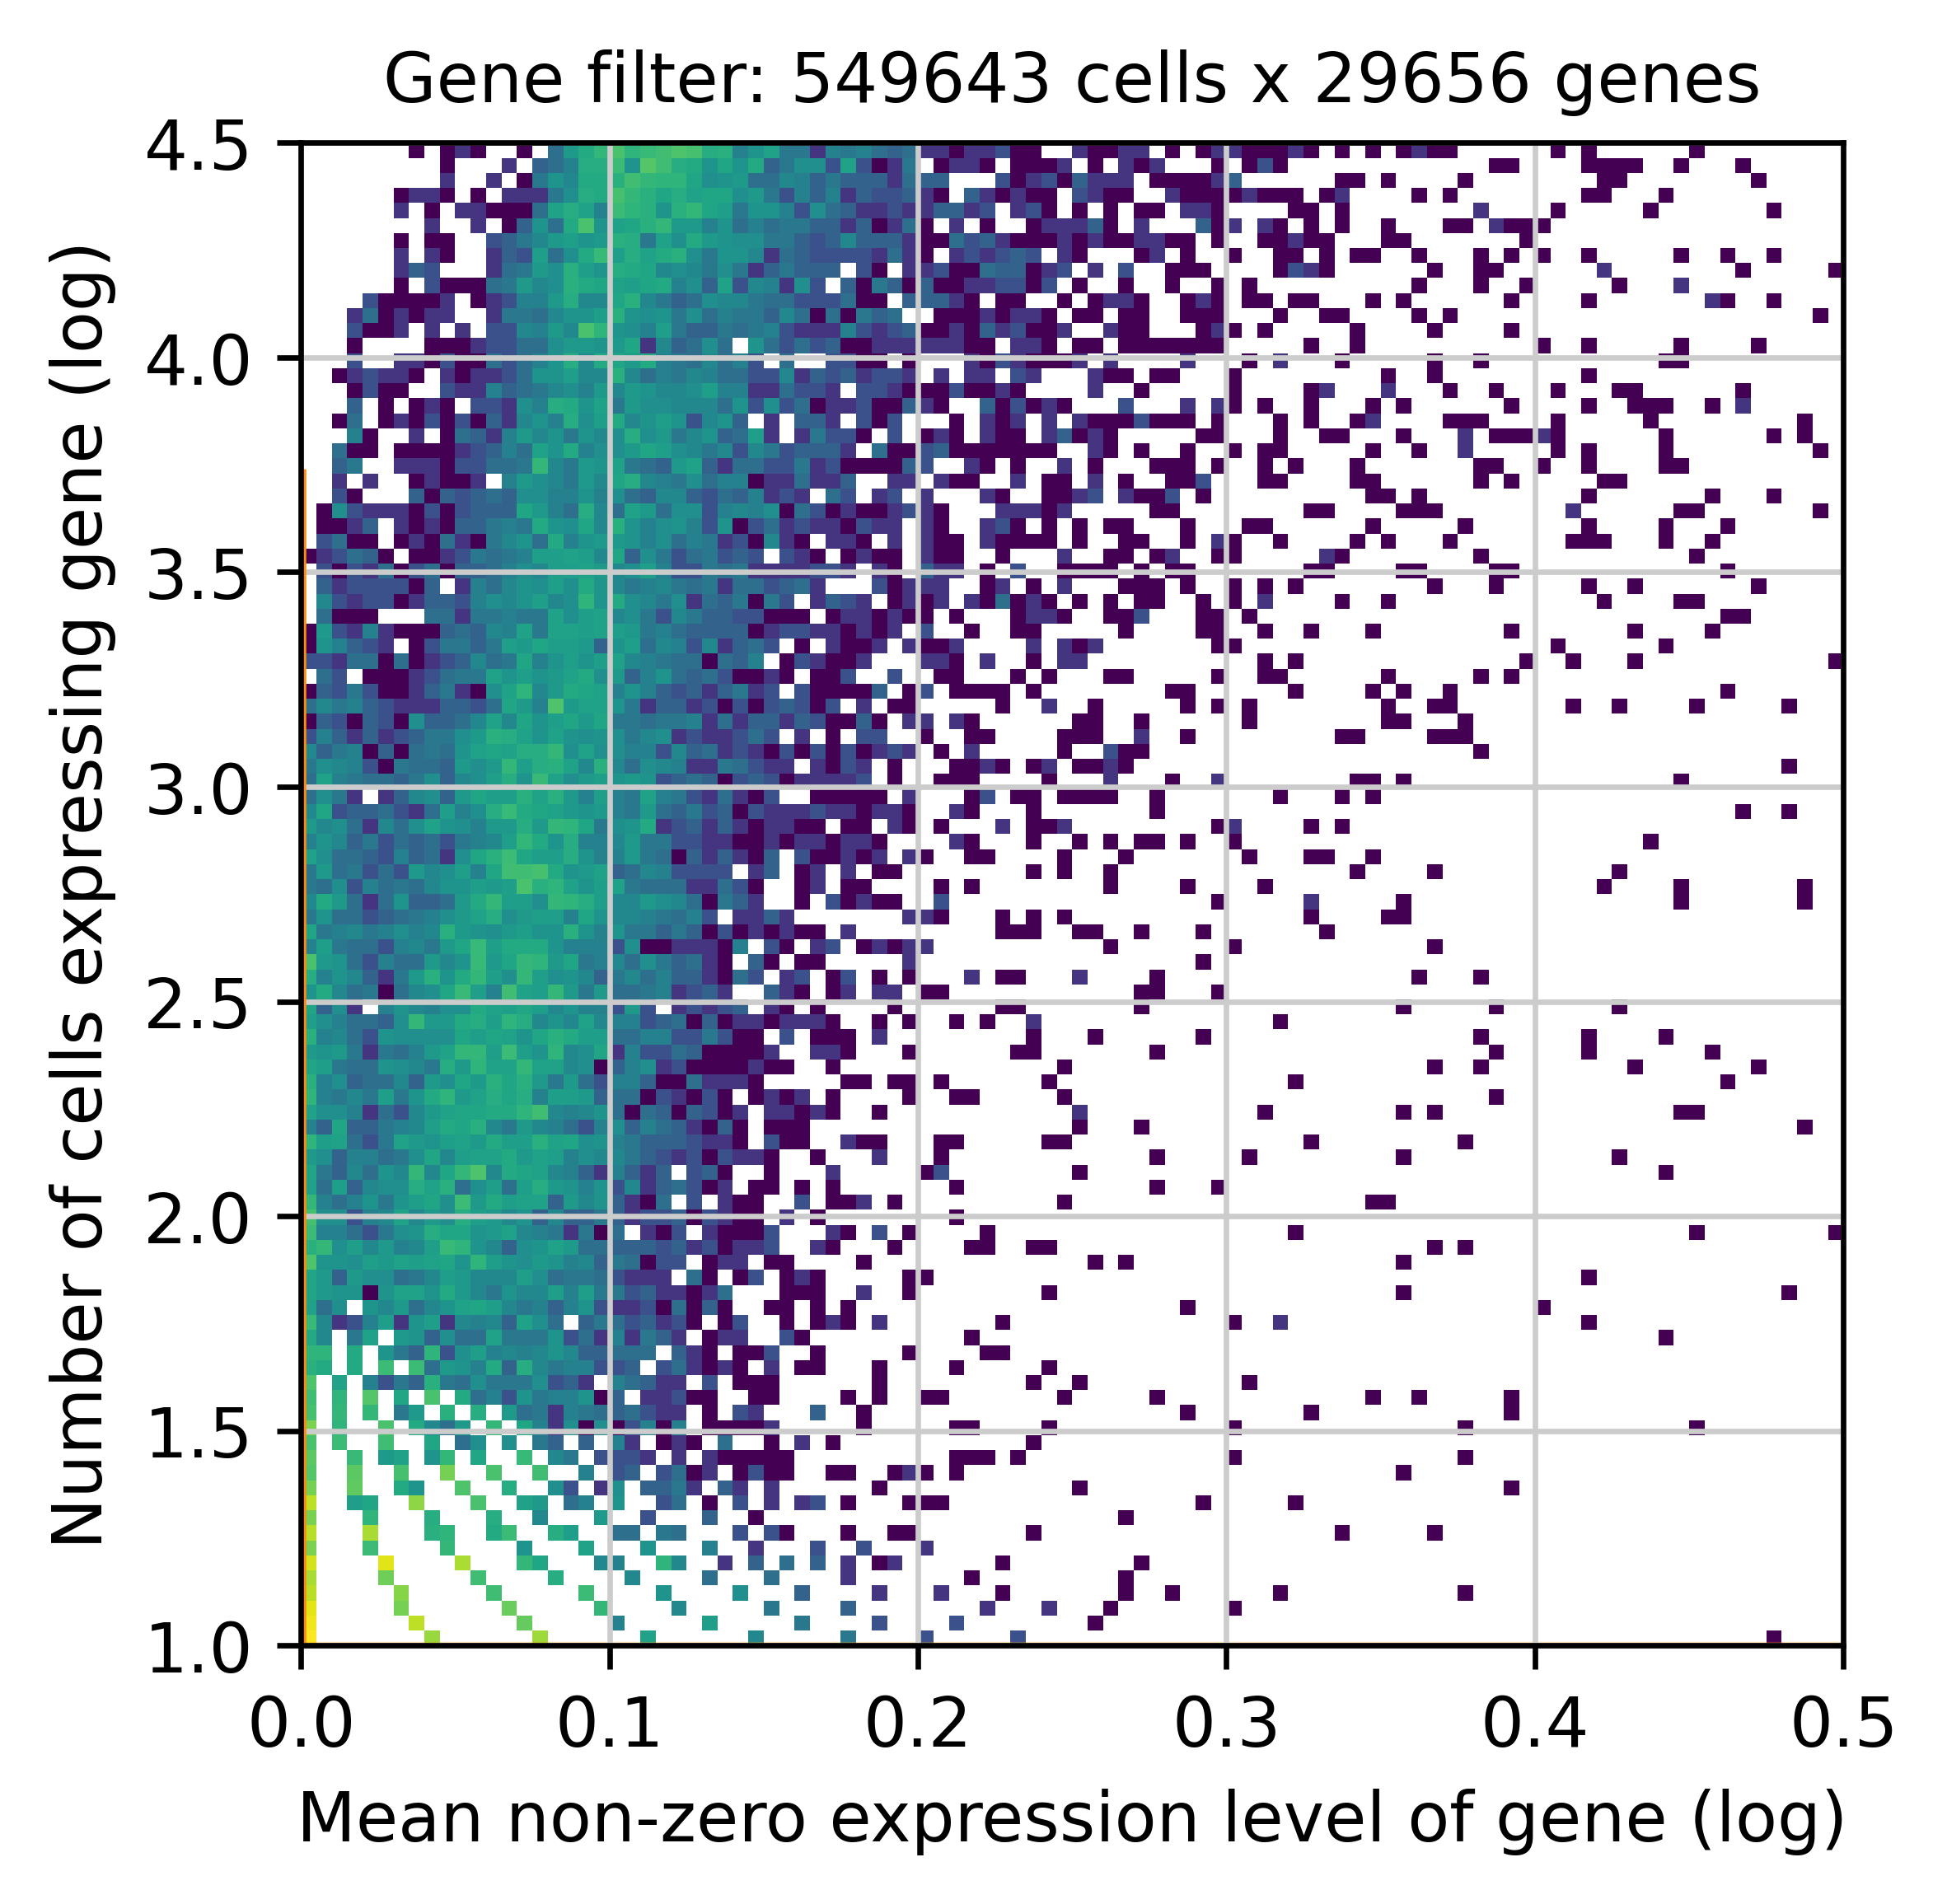

In [8]:
#filtering
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.01, nonz_mean_cutoff=1.00)
adata_ref = adata_ref[:, selected].copy()

In [10]:
###Estimation of reference cell type signatures (NB regression)
#prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(
    adata=adata_ref,
    batch_key='orig.ident', #10x reaction / sample / batch
    labels_key='celltype', #cell type, covariate used for constructing signatures
    categorical_covariate_keys= ['Centrifugation']
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [11]:
#create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.6.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'orig.ident',
│   'labels_key': 'celltype',
│   'categorical_covariate_keys': ['Centrifugation'],
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   60   │
│         n_cells          │ 549643 │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   26   │
│          n_vars          │ 29656  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                       batch State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃   Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['orig.ident'] │    CTRL-173     │          0          │
│                         │  CTRL-173-Hepa  │          1          │
│                         │    CTRL-175     │          2          │
│                         │  CTRL-175-Hepa  │          3          │
│                         │    CTRL-184     │          4          │
│                         │  CTRL-184-Hepa  │          5          │
│                         │    CTRL-371     │          6          │
│                         │  CTRL-371-Hepa  │          7          │
│                         │    CTRL-5113    │          8          │
│                         │ CTRL-5113-Hepa  │          9          │
│                         │    CTRL-5759    │         10          │
│                         │ CTRL-5759-Hepa  │         11          │
│                         │    CTRL-8715    │         12          │
│                         │ CTRL-8715-Hepa  │         13          │
│                         │    MASH-0114    │         14          │
│                         │ MASH-0114-Hepa  │         15          │
│                         │    MASH-0269    │         16          │
│                         │ MASH-0269-Hepa  │         17          │
│                         │    MASH-1486    │         18          │
│                         │ MASH-1486-Hepa  │         19          │
│                         │    MASH-1505    │         20          │
│                         │ MASH-1505-Hepa  │         21          │
│                         │    MASH-1509    │         22          │
│                         │ MASH-1509-Hepa  │         23          │
│                         │    MASH-1531    │         24          │
│                         │ MASH-1531-Hepa  │         25          │
│                         │    MASH-1546    │         26          │
│                         │ MASH-1546-Hepa  │         27          │
│                         │    MASH-2016    │         28          │
│                         │ MASH-2016-Hepa  │         29          │
│                         │    MASH-2134    │         30          │
│                         │ MASH-2134-Hepa  │         31          │
│                         │    MASH-2800    │         32          │
│                         │ MASH-2800-Hepa  │         33          │
│                         │    MASH-3800    │         34          │
│                         │ MASH-3800-Hepa  │         35          │
│                         │    MASH-4366    │         36          │
│                         │ MASH-4366-Hepa  │         37          │
│                         │    MASH-5619    │         38          │
│                         │ MASH-5619-Hepa  │         39          │
│                         │    MASH-5846    │         40          │
│                         │ MASH-5846-Hepa  │         41          │
│                         │    MASH-6202    │         42          │
│                         │ MASH-6202-Hepa  │         43          │
│                         │    MASH-8461    │         44          │
│                         │ MASH-8461-Hepa  │         45          │
│                         │   MASLD-0003    │         46          │
│                         │ MASLD-0003-Hepa │         47          │
│                         │   MASLD-0910    │         48          │
│                         │ MASLD-0910-Hepa │         49          │
│                         │   MASLD-1483    │         50          │
│                         │ MASLD-1483-Hepa │         51          │
│                         │   MASLD-1500    │         52          │
│                         │ MASLD-1500-Hepa │         53          │
│                         │   MASLD-1504    │         54

                        labels State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃      Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['celltype'] │       Bmemory        │          0          │
│                       │        Bnaive        │          1          │
│                       │    CD14+ Monocyte    │          2          │
│                       │    CD16+ Monocyte    │          3          │
│                       │   Central Vein EC    │          4          │
│                       │    Cholangiocyte     │          5          │
│                       │ Circulating NK cell  │          6          │
│                       │ Circulating NKT cell │          7          │
│                       │         HSC          │          8          │
│                       │      Hepatocyte      │          9          │
│                       │          KC          │         10          │
│                       │         LAM          │         11          │
│                       │         LSEC         │         12          │
│                       │         MAIT         │         13          │
│                       │      Mast cell       │         14          │
│                       │      Neutrophil      │         15          │
│                       │      Plasma_IgA      │         16          │
│                       │      Plasma_IgG      │         17          │
│                       │    Portal Vein EC    │         18          │
│                       │   Resident NK cell   │         19          │
│                       │         Teff         │         20          │
│                       │        Tnaive        │         21          │
│                       │         Treg         │         22          │
│                       │         cDC1         │         23          │
│                       │         cDC2         │         24          │
│                       │         pDC          │         25          │
└───────────────────────┴──────────────────────┴─────────────────────┘

              extra_categorical_covs State Registry               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location       ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Centrifugation'] │    NPC     │          0          │
│                             │    PCs     │          1          │
│                             │            │                     │
└─────────────────────────────┴────────────┴─────────────────────┘

In [12]:
#Training NB model
mod.train(max_epochs=500, batch_size=2500, train_size=1)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/bailab/miniconda3/envs/cell2location/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL

Epoch 500/500: 100%|██████████| 500/500 [13:48:57<00:00, 100.27s/it, v_num=1, elbo_train=2.88e+9]  

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [13:48:57<00:00, 99.48s/it, v_num=1, elbo_train=2.88e+9] 


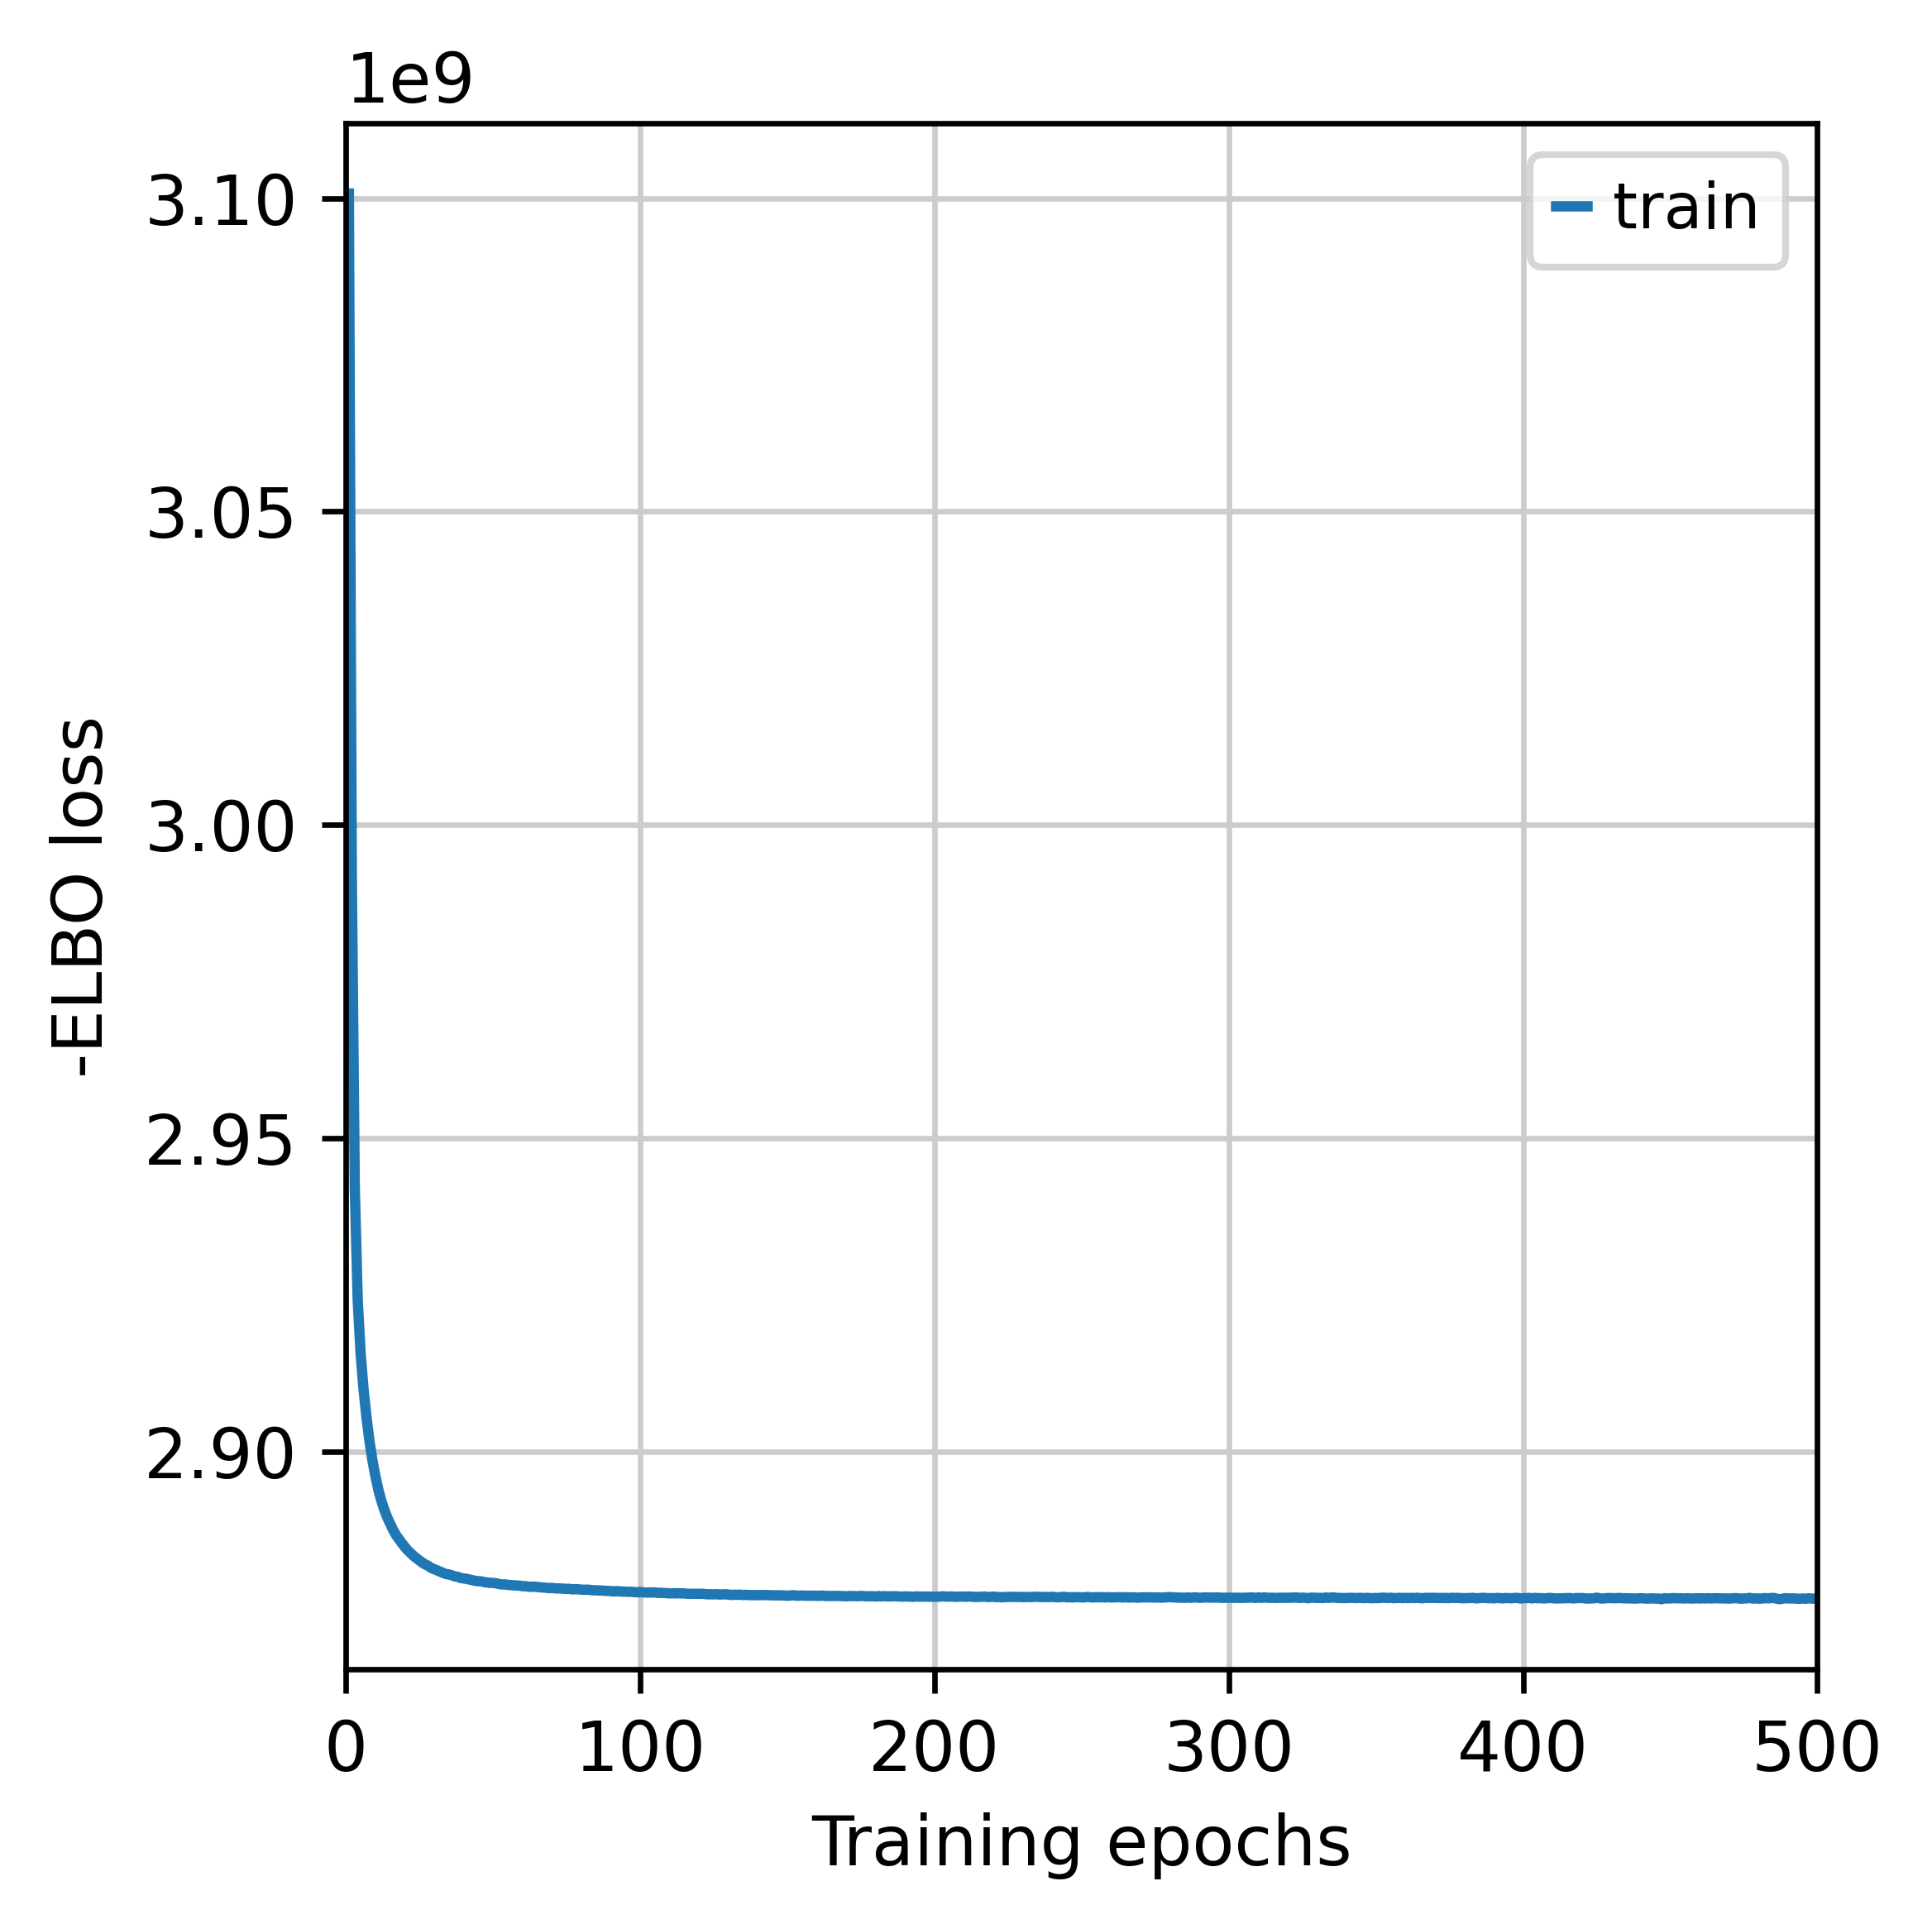

In [13]:
#Determine if the model needs more training
mod.plot_history(1)

In [14]:
#We export the estimated cell abundance (summary of the posterior distribution)
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples':1000, 'batch_size':2500}
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Sampling global variables, sample: 100%|██████████| 999/999 [00:22<00:00, 44.55it/s]


In [15]:
#Save model
mod.save(f'{ref_run_name}', overwrite=True)

#Save anndata object with results
adata_ref.write(f"{ref_run_name}/adata_ref.h5ad")

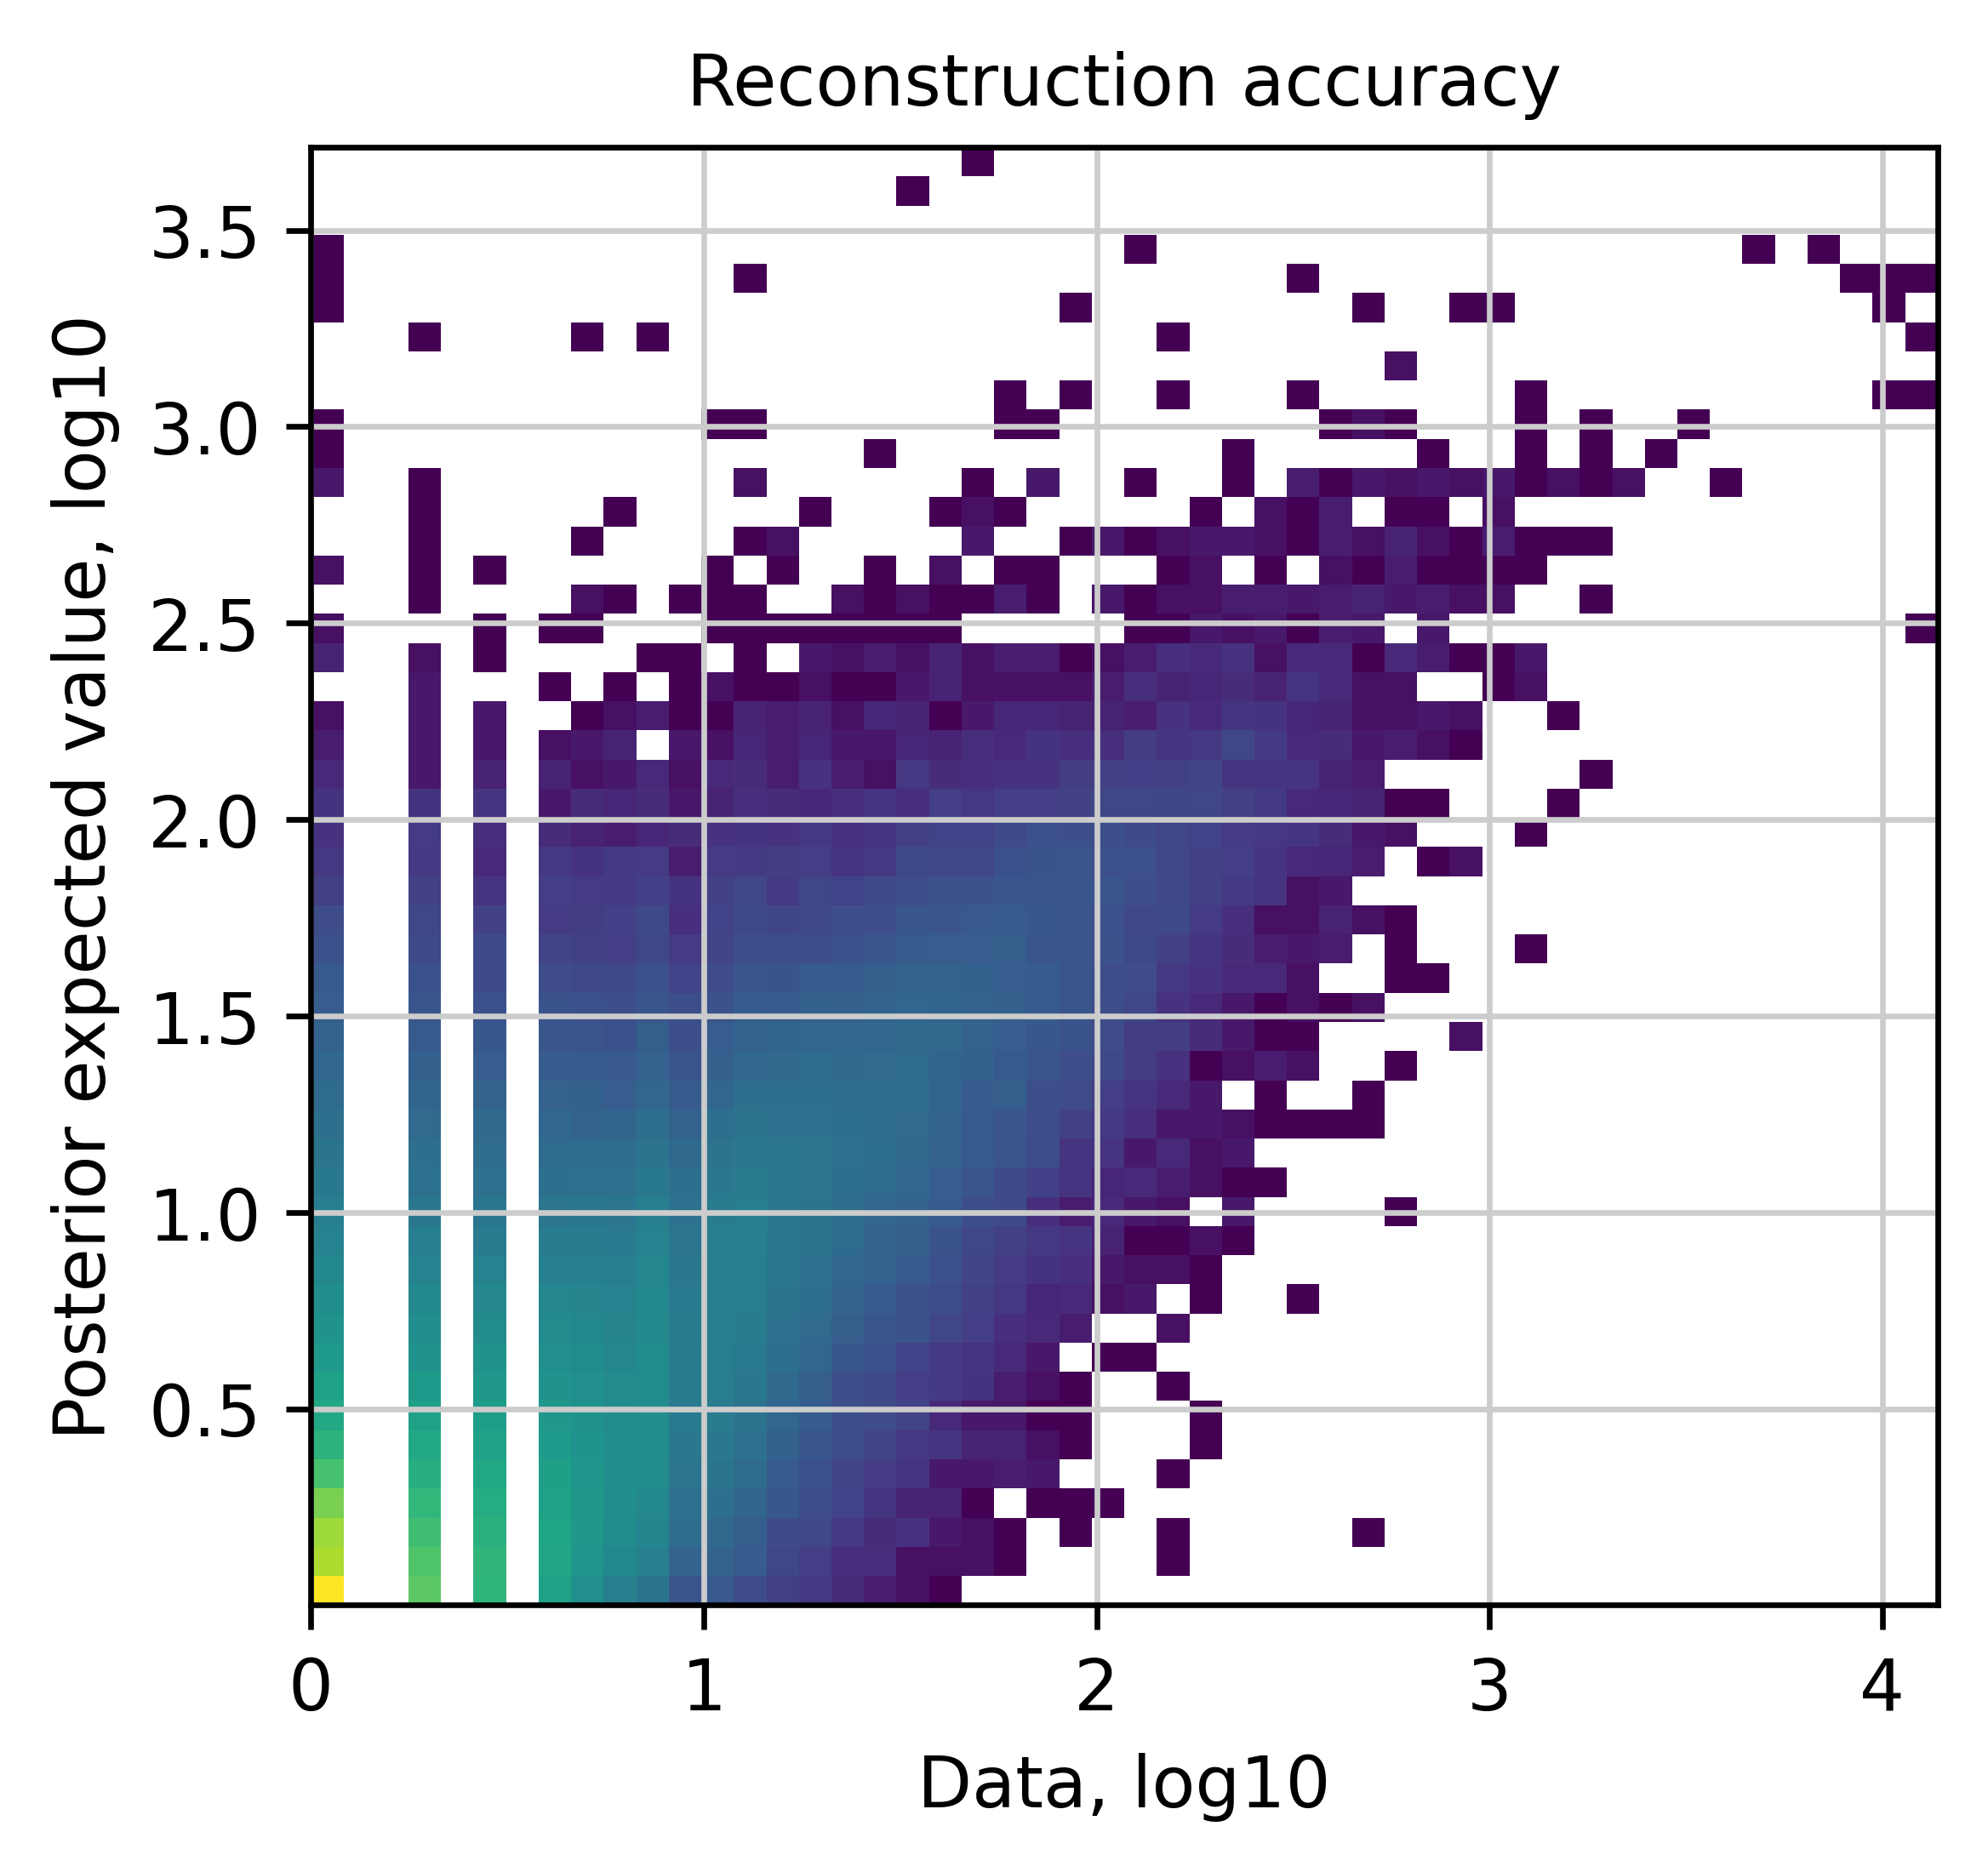

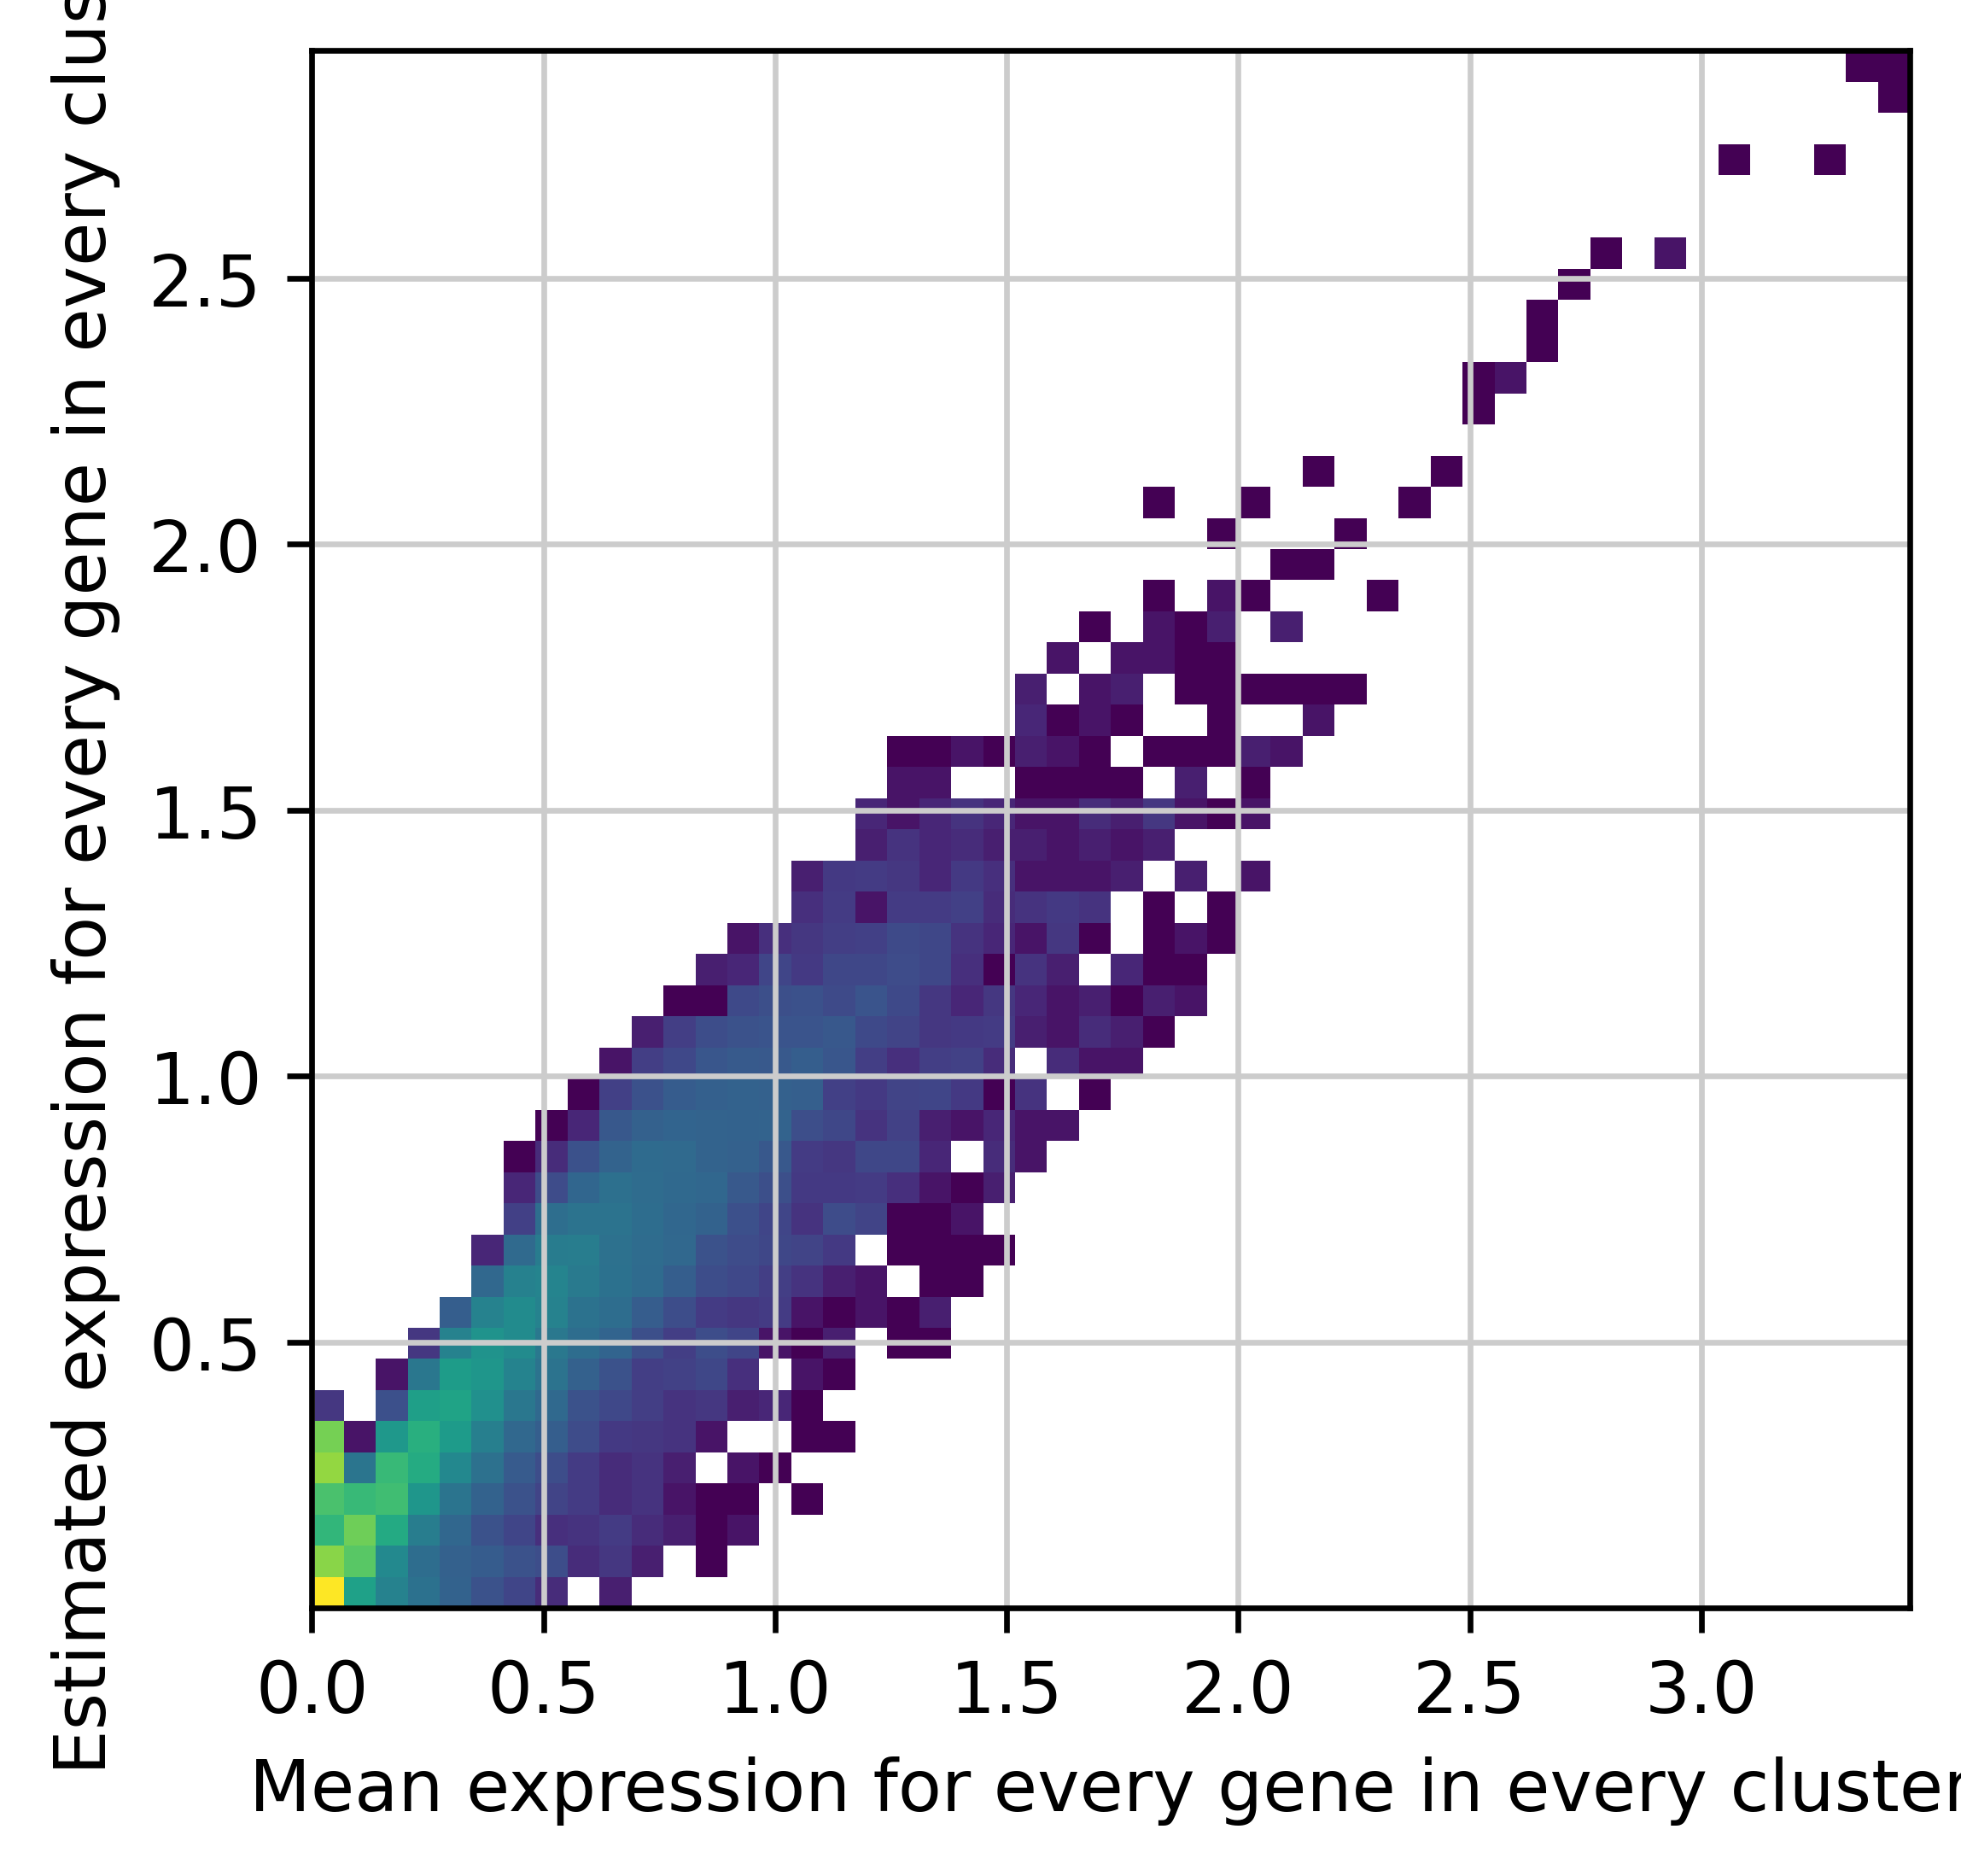

In [16]:
#Examine QC plots
mod.plot_QC()

In [ ]:
#Reload model and output h5ad
adata_ref = sc.read_h5ad(f"{ref_run_name}/adata_ref.h5ad")
mod = cell2location.models.RegressionModel.load(f'{ref_run_name}', adata_ref)

In [17]:
#For spatial mapping we just need the estimated expression of every gene in every cell type
#Here we extract that from standard output:
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' for i in adata_ref.uns['mod']['factor_names']]].copy()

inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

Bmemory    Bnaive  CD14+ Monocyte  CD16+ Monocyte  Central Vein EC
A1BG      0.004006  0.002987        0.003322        0.004915         0.008110
A1BG-AS1  0.060397  0.047239        0.092994        0.076125         0.003468
A1CF      0.002285  0.003183        0.004961        0.007755         0.001635
A2M       0.055183  0.030066        0.123829        0.470566         8.526412
A2M-AS1   0.003832  0.001203        0.013270        0.022009         0.045167

In [22]:
# Save inf_aver results
inf_aver.to_csv(f'{ref_run_name}/inf_aver.csv',index=True)
inf_aver = pd.read_csv(f'{ref_run_name}/inf_aver.csv',index_col=0)

In [42]:
inf_aver.apply(lambda x: x.nlargest(100))

B cells  Basophils  CD8+ T_SLC4A10  Cholangiocytes  \
A2M         NaN        NaN             NaN             NaN   
ACP5        NaN        NaN             NaN             NaN   
ACSL1       NaN        NaN             NaN             NaN   
ACTA2       NaN        NaN             NaN             NaN   
ACTB   5.504096   6.150935        7.005521        8.929358   
...         ...        ...             ...             ...   
XBP1        NaN        NaN             NaN             NaN   
XCL1        NaN        NaN             NaN             NaN   
XCL2        NaN        NaN             NaN             NaN   
YBX1        NaN        NaN             NaN             NaN   
ZFP36       NaN   5.319926        3.704742             NaN   

       Circulating NK/NKT       HSCs  Hepatocytes  KCs/moKCs       LAMs  \
A2M                   NaN        NaN          NaN        NaN  16.296148   
ACP5                  NaN        NaN          NaN        NaN  16.144451   
ACSL1                 NaN        NaN          NaN        NaN        NaN   
ACTA2                 NaN  28.321472          NaN        NaN        NaN   
ACTB             6.555378  10.803877          NaN  26.679361  43.405952   
...                   ...        ...          ...        ...        ...   
XBP1                  NaN        NaN          NaN        NaN        NaN   
XCL1                  NaN        NaN          NaN        NaN        NaN   
XCL2                  NaN        NaN          NaN        NaN        NaN   
YBX1                  NaN        NaN          NaN        NaN  13.332293   
ZFP36                 NaN        NaN          NaN        NaN        NaN   

           LECs     LVECs  Monocytes  Neutrophils  Plasma cells  Resident NK  \
A2M    5.777122  9.359909        NaN          NaN           NaN          NaN   
ACP5   6.473387       NaN        NaN          NaN           NaN          NaN   
ACSL1       NaN       NaN        NaN     1.824994           NaN          NaN   
ACTA2       NaN       NaN        NaN          NaN           NaN          NaN   
ACTB   3.219655  4.892899  35.394590     6.240322      6.998455     7.249104   
...         ...       ...        ...          ...           ...          ...   
XBP1        NaN       NaN        NaN          NaN     16.902325          NaN   
XCL1        NaN       NaN        NaN          NaN           NaN     5.782828   
XCL2        NaN       NaN        NaN          NaN           NaN     5.175199   
YBX1        NaN       NaN        NaN          NaN           NaN          NaN   
ZFP36       NaN       NaN  13.200227     3.459180           NaN     3.284021   

        T cells    Tnaive      cDC1s      cDC2s       pDCs  
A2M         NaN       NaN        NaN        NaN        NaN  
ACP5        NaN       NaN        NaN        NaN        NaN  
ACSL1       NaN       NaN        NaN        NaN        NaN  
ACTA2       NaN       NaN        NaN        NaN        NaN  
ACTB   6.944608  8.511409  81.165955  42.596794  18.790014  
...         ...       ...        ...        ...        ...  
XBP1        NaN       NaN        NaN        NaN        NaN  
XCL1        NaN       NaN        NaN        NaN        NaN  
XCL2        NaN       NaN        NaN        NaN        NaN  
YBX1        NaN       NaN        NaN        NaN        NaN  
ZFP36       NaN       NaN        NaN        NaN   6.955937  

[591 rows x 20 columns]

In [ ]:
sc.pl.correlation_matrix(adata[:, adata.var.highly_variable], 'cell_type_lvl2', figsize=(12, 8), cmap='RdBu_r', save='celltype_correlation.pdf', show_correlation_numbers=True)